# How to use the calibration utility

This tool calibrates the input internally-calibrated continuously-represented mean spectra to the absolute system.

Information about the units of the variables used in this tutorial can be found [here](https://gaiaxpy.readthedocs.io/en/latest/description.html#general-description).

## Basic usage

In [1]:
# Import the tool
from gaiaxpy import calibrate
# Path to file with XP CONTINUOUS RAW data (csv, ecsv, fits, or xml)
f = '/home/drm/GaiaXPy/tests/files/xp_continuous/XP_CONTINUOUS_RAW_votable_dr3int6.xml'

#### The calibrator returns two different outputs: 

 1. The calibrated spectra which is a pandas DataFrame.
 2. The sampling passed to the function which is a NumPy array. If no sampling is given, the default sampling  is returned. The default sampling is generated internally and it corresponds to numpy.arange(336., 1201., 2.) in absolute wavelengths [nm].

In [2]:
calibrated_spectra, sampling = calibrate(f)
calibrated_spectra

source_id                                               flux  \
0          6  [3.3061011831503994e-16, 2.0851507135729609e-1...   
1          4  [7.09946308187746e-16, 7.468755979569835e-16, ...   

                                          flux_error  
0  [6.844831355486753e-17, 5.053342350076037e-17,...  
1  [3.0615967325258556e-17, 2.6911400287828394e-1...

### Input types

The input does not have to be a path to a file. There are other options: a pandas DataFrame, an ADQL query or a list of sourceIds.

#### Passing a DataFrame

In [3]:
import pandas as pd

f = '/home/drm/GaiaXPy/tests/files/xp_continuous/XP_CONTINUOUS_RAW_dr3int6.csv'
df = pd.read_csv(f) # The values in the DataFrame can be edited if the user wishes to do so.

calibrated_spectra, sampling = calibrate(df)
calibrated_spectra

source_id                                               flux  \
0          6  [3.3061011831503994e-16, 2.0851507135729609e-1...   
1          4  [7.09946308187746e-16, 7.468755979569835e-16, ...   

                                          flux_error  
0  [6.8448313369303e-17, 5.053342410477518e-17, 4...  
1  [3.061596764280633e-17, 2.691140012604713e-17,...

#### Running a query

**Important note**: Currently the data in the Gaia Archive is not public. The following code will <span style="color:red">not</span> work until DR3.

In [4]:
query_input = "select TOP 2 source_id from user_dr3int6.gaia_source where has_xp_continuous = 'True'"
calibrated_spectra, sampling = calibrate(query_input)
calibrated_spectra

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: druzmier
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]


source_id                                               flux  \
0  6030020833890693248  [1.0889393118065536e-17, 4.3736928587318126e-1...   
1  6030064028385961344  [1.3439396089013387e-17, 1.065320957332169e-17...   

                                          flux_error  
0  [4.3045448931595826e-18, 3.189911309054001e-18...  
1  [8.276016416437735e-18, 6.007360222456866e-18,...

#### Passing a list

A list of sourceIds can be passed to the calibrator as the first argument. The calibrator then will query the Archive for these objects.

In [5]:
sources_list = ['6030020833890693248', 6030064028385961344] # The sourceIds can be string or long.
calibrated_spectra, sampling = calibrate(sources_list)
calibrated_spectra

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: druzmier
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


source_id                                               flux  \
0  6030020833890693248  [1.0889393118065536e-17, 4.3736928587318126e-1...   
1  6030064028385961344  [1.3439396089013387e-17, 1.065320957332169e-17...   

                                          flux_error  
0  [4.3045448931595826e-18, 3.189911309054001e-18...  
1  [8.276016416437735e-18, 6.007360222456866e-18,...

## Advanced usage

Additional arguments can be passed to the calibrator.

These are:
1. sampling
2. truncation
3. output_path
3. output_file
4. output_format
5. save_file

### Sampling

A sampling can be passed to the function. This sampling should be an iterable (list, tuple, generator, or preferably a NumPy array). If no sampling is given, the default sampling is used and returned.

The default sampling of the calibrator corresponds to numpy.arange(336., 1201., 2.) in absolute wavelengths [nm], and it is generated internally when no sampling is explicitly passed to the function.

The minimum value allowed in the sampling is 330, and the maximum is 1050. The program will raise an error is the sampling does not comply.

The sampling can be tailored to the needs of specific science cases. For example, the sampling numpy.geomspace(330,1049.9999999999, 361) could be employed to improve the resolution at the blue end.

In [6]:
import numpy as np

sampling = np.geomspace(330,1049.9999999999, 361)
calibrated_spectra_geom, sampling = calibrate(f, sampling=sampling)
calibrated_spectra_geom

source_id                                               flux  \
0          6  [-1.7133800811181398e-17, 3.940203196397507e-1...   
1          4  [9.837714939217614e-16, 7.1187629272373e-16, 6...   

                                          flux_error  
0  [5.924248722349272e-16, 3.1671235784888886e-16...  
1  [1.5154469870589605e-16, 8.992874542421584e-17...

We can compare the results of the default sampling and the suggested one for sourceId 6.

In [7]:
first_source = df.iloc[[0]] # Select row with index 0
first_spectra, sampling = calibrate(first_source) 
first_spectra_geom, geom_sampling = calibrate(first_source, sampling=np.geomspace(330,1049.9999999999, 361))

Default sampling


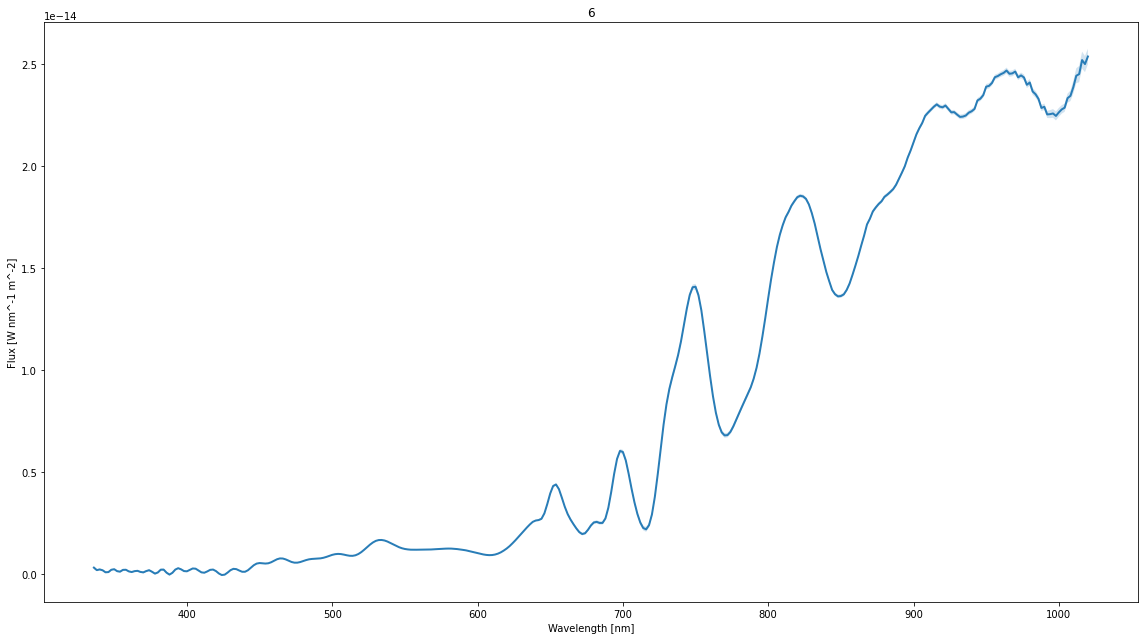

Geometric progression (log) sampling


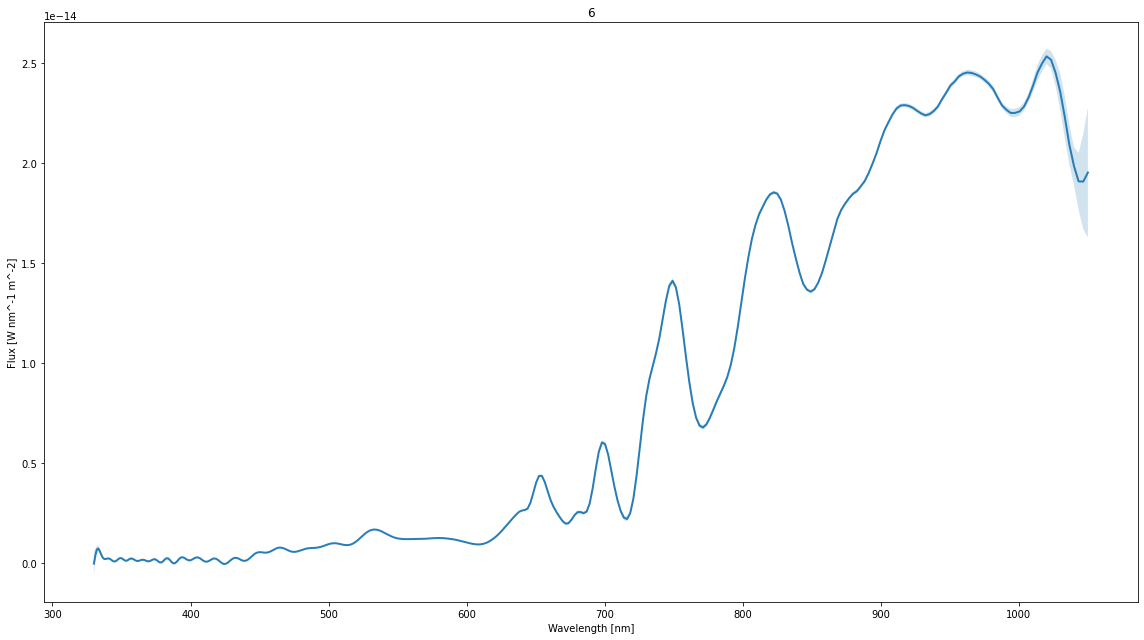

In [8]:
from gaiaxpy import plot_spectra

print('Default sampling')
# Do not show the legend as there's only one source in the data
plot_spectra(first_spectra, sampling=sampling, legend=False)
print('Geometric progression (log) sampling')
plot_spectra(first_spectra_geom, sampling=geom_sampling, legend=False)

### Truncation

The source mean BP/RP spectrum is described as a combination of basis functions. Particularly for faint sources or sources with a low number of observations, it is useful to represent the spectrum using a smaller set of basis functions to avoid higher-order bases fitting the noise in the observed data.

The truncation parameter is a boolean which toggles the truncation of the set of bases.

In [9]:
second_source = df.drop([0]) # We'll use only the second source (sourceId 4) in the demonstration
non_truncated_spectra, sampling = calibrate(second_source) # truncation is False by default
truncated_spectra, _ = calibrate(second_source, truncation=True)

We can use GaiaXPy's plot spectra utility to see the differences in the results.

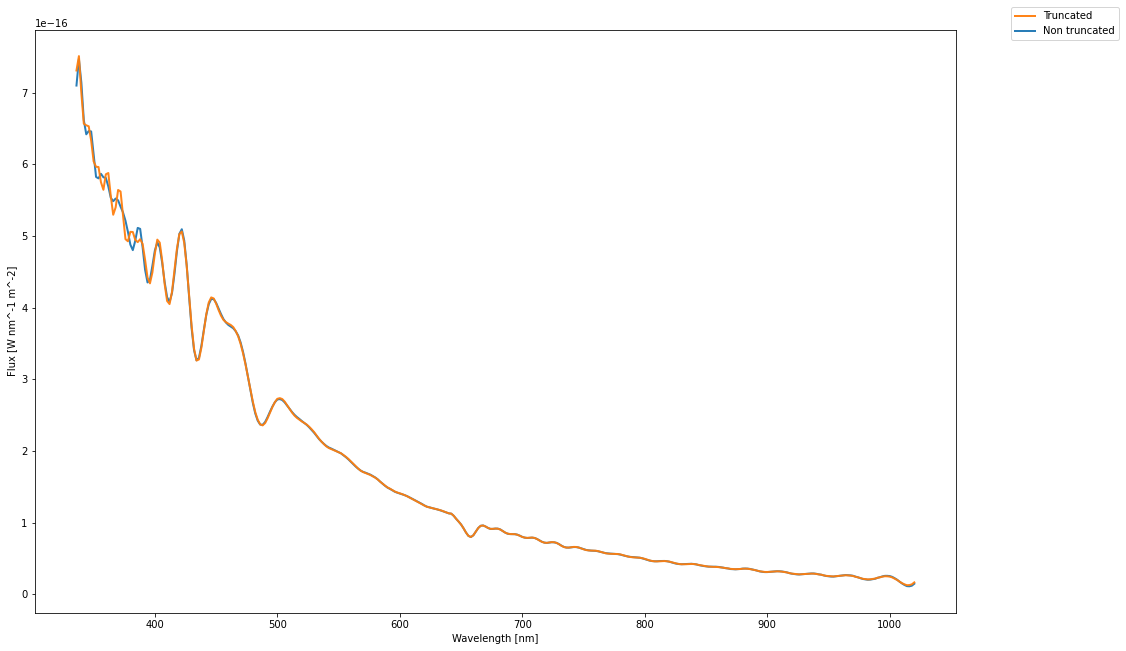

In [10]:
from gaiaxpy import plot_spectra
# Construct a DataFrame so we can plot both sources using just one function call
data = pd.concat([non_truncated_spectra, truncated_spectra]).reset_index(drop=True)
# As both spectra we want to plot have the same sourceId, we'll rename them to get descriptive labels
data['source_id'][0] = 'Non truncated'
data['source_id'][1] = 'Truncated'
plot_spectra(data, sampling=sampling, multi=True)

### Output_path, output_file, output_format, save_file

Three parameters: **output_path**, **output_file**, and **output_format** define the entire path of the resulting file.

The default output path is the current path. If the given output path does not exist, it will be created.

The default output file name is 'output_spectra'. 

The default output format is the format of the input file (i.e. if the input file is a 'fits', then the output file will be a FITS file by default.), or CSV in any other case (DataFrame, ADQL query or list).

**NOTE: If a file with the same path and name already exists, it will be AUTOMATICALLY OVERWRITTEN.**

In [11]:
calibrated_spectra, _ = calibrate(f, output_path='/home/drm/Desktop', output_file='my_file', output_format='fits')

The additional parameter **save_file** is a boolean that tells the program whether to save the results or not.
If 'output_file' is given but 'save_file' is set to False, a warning will be raised.

In [12]:
calibrated_spectra, _ = calibrate(f, output_file='my_file', output_format='.xml', save_file=False)

/home/drm/GaiaXPy/gaiaxpy/core/generic_functions.py:46: UserWarning: Argument output_file was given, but save_file is set to False. Set save_file to True to store the output of the function.
  warn('Argument output_file was given, but save_file is set to False. Set save_file to True to store the output of the function.')
